In [ ]:
#@title **Information**
%%html
<marquee style='width: 50%; color: white;'><b>Dylan Govender (221040222) - COMP700</b></marquee>

## **Abstract**

Lung cancer is a significant contributor to cancer-related mortality. With recent advancements in Computer Vision, Vision Transformers have gained traction and shown remarkable success in medical image analysis. This study explores the potential of Vision Transformer models (ViT, CvT, Parallel-ViT, CCT ViT) compared to established state-of-the-art architectures (CNN) for lung cancer detection via medical imaging modalities, including CT scans and X-rays. This work will evaluate the impact of data availability and different training approaches on model performance. The training approaches considered include but are not limited to Supervised Learning and Transfer Learning. Established evaluation metrics such as accuracy, recall, precision, F1-score, and area under the ROC curve (AUC-ROC) will assess model performance in detection efficacy, data validity, and computational efficiency. Cost-sensitive evaluation metrics such as cost matrix and weighted loss will analyse model performance by considering the real-world implications of different types of errors, especially in cases where misdiagnosing a cancer case is more critical.

## **Vision Transformer from Scratch on Lung Cancer CT Scan Images**

In this notebook, we are going to train various Vision Transformer (ViT) Models (including interesting variants) from scratch on the [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code). This dataset contains a total of 1190 images representing CT scan slices of 110 lung cancer cases. These cases are grouped into three classes: normal, benign, and malignant. Of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases.

We will prepare the data using [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code), and train the model using [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning).

## **Quick Introduction: Vision Transformer (ViT) by Google Brain**

The Vision Transformer (ViT) is basically BERT, but applied to images. This research will see how the ViT compares to state-of-the-art (SOTA) CNN Models. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. Additionally, we can add a [CLS] token at the beginning of the sequence in order to classify images. Next, we can add an absolute position embedding which provides this sequence to the Transformer Encoder.


* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

## 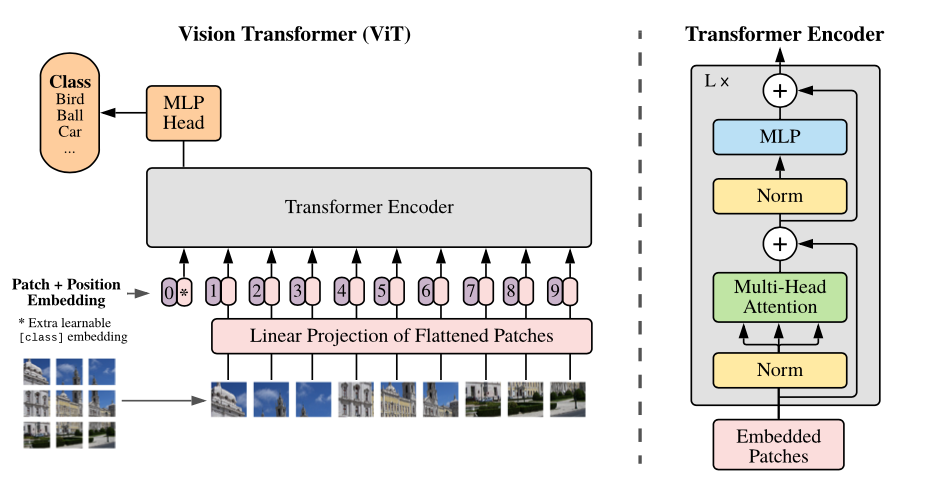


## **Quick Introduction: CvT**

CvT proposes combining convolutions and attention. Specifically, the convolutions are used to embed and downsample the image / feature map in three stages. Depthwise-convoltion is also used to project the queries, keys, and values for attention. The pipeline of the proposed CvT architecture. (a) Overall architecture, showing the hierarchical multi-stage structure facilitated by the Convolutional Token Embedding layer. (b) Details of the Convolutional Transformer Block, which contains the convolution projection as the first layer.

* Paper: https://arxiv.org/abs/2104.14294


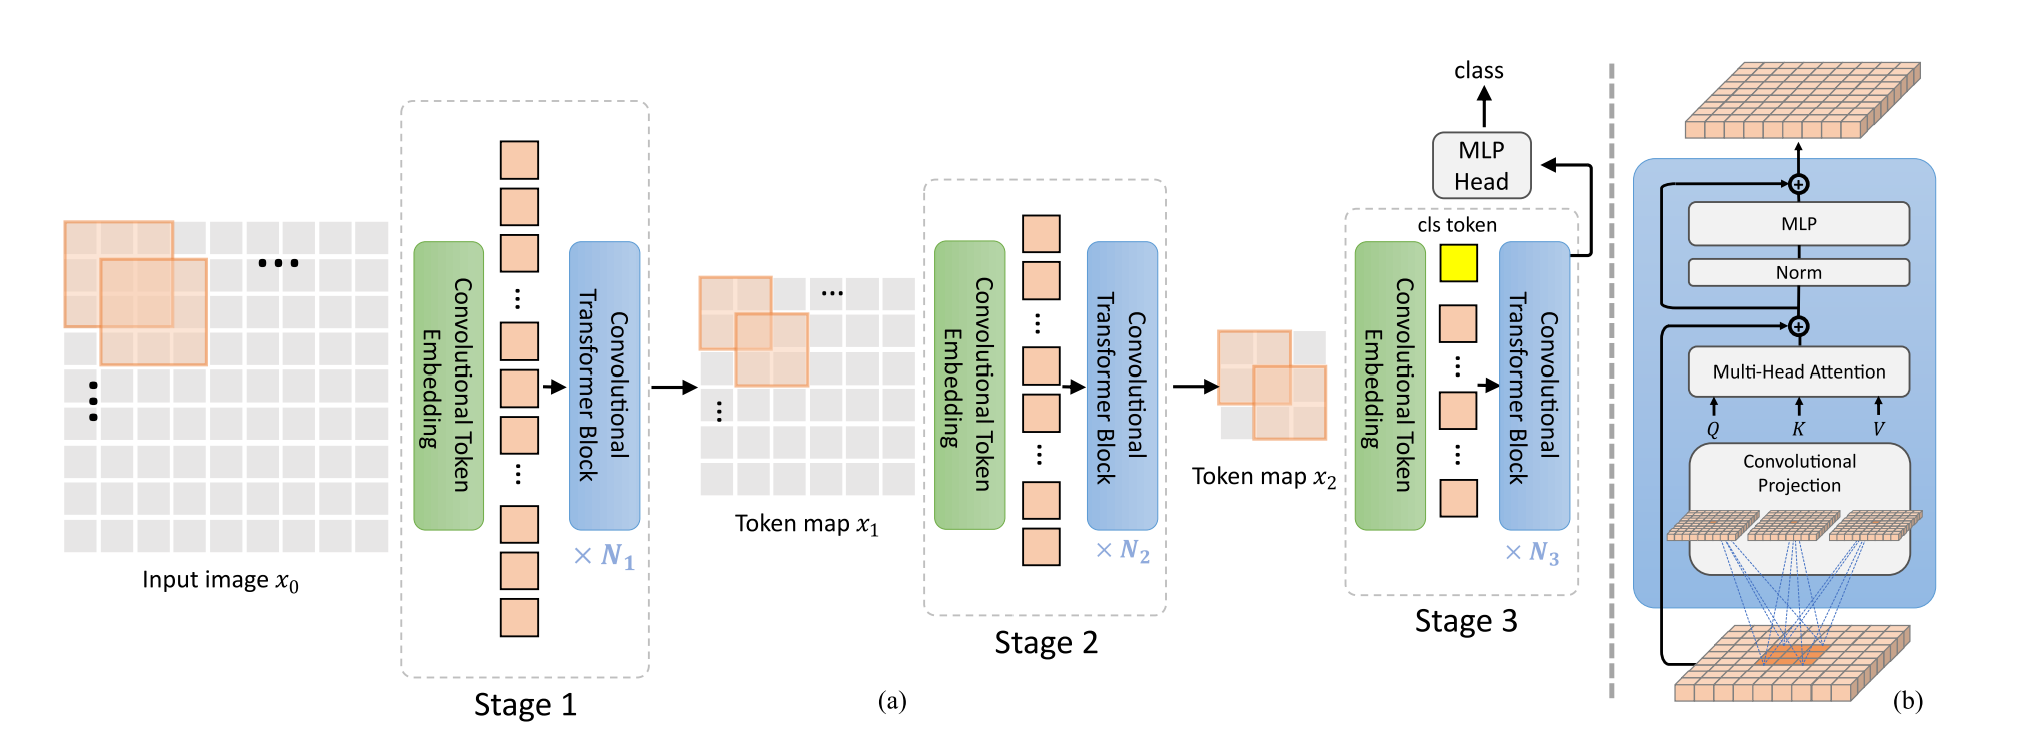

# **1. Downloading Dependencies and Data**

In [ ]:
#@title **1.1 Downloading Dependencies**

# for capturing output
%%capture

# Dependencies
!pip install transformers
!pip install datasets
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
#@title **1.2 Downloading Data**

# for capturing output
%%capture

# Data
!cp '/content/drive/MyDrive/Honours Project/Datasets/IQ-OTHNCCD_Lung_Cancer_Dataset.zip' 'IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!unzip '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!rm '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

# **2. Importing the Data**

In [ ]:
#@title **2.1 Extracting the data.**

import os
import pandas as pd
import matplotlib.pyplot as plt

normal_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
benign_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
dir = [normal_dir, benign_dir, malignant_dir]

classes = ['benign', 'malignant', 'normal']

labels = []
filepaths = []

for i, directory in enumerate(dir):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        filepaths.append(filepath)
        labels.append(classes[i])

file_series = pd.Series(filepaths, name="filepaths")
label_series = pd.Series(labels, name="labels")
lung_data = pd.concat([file_series, label_series], axis=1)
df = pd.DataFrame(lung_data)
df.head()

,filepaths,labels
0,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
1,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
2,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
3,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
4,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign


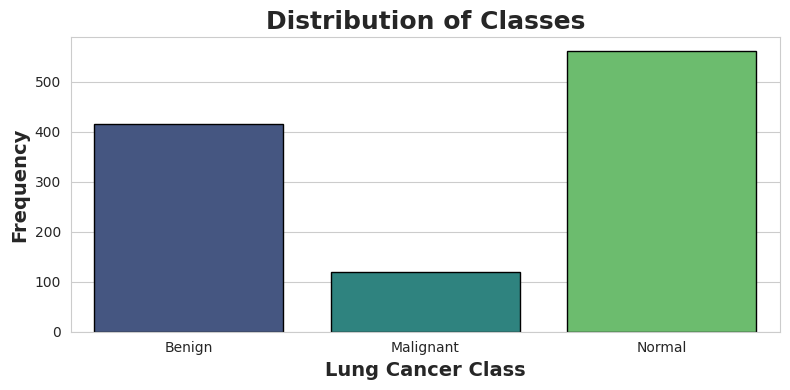

In [ ]:
#@title **2.2 Plotting the Lung Cancer Distribution Graph**

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SIZE = (8, 4)

def plot_distribution(df, attribute, title, x_label, y_label, size=SIZE):
    # set a seaborn style for a more polished look
    sns.set_style("whitegrid")

    # adjust figure size
    plt.figure(figsize=size)

    # create the count plot with enhanced color palette and edge color
    sns.countplot(x=attribute, data=df, hue=attribute, palette="viridis", edgecolor='black', legend=False)

    # set labels and title with customized font sizes
    plt.xticks(ticks=plt.gca().get_xticks(), labels=[label.get_text().capitalize() for label in plt.gca().get_xticklabels()])
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')

    # improve the layout
    plt.tight_layout()

    # show the plot
    plt.show()

attribute = 'labels'
title = 'Distribution of Classes'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(df, attribute, title, x_label, y_label)

In medical datasets, data is scarce and readily available. This limited availability often leads to imbalanced distributions of images, which can result in biased or inaccurate model performance. For instance, if one class (Normal) significantly outnumbers other classes (Malignant or Benign), a model may struggle to detect the minority classes accurately (in this case Malignant or Benign), leading to poor generalization. This issue is particularly problematic in medical image classification tasks, where accurate detection of rare cases, such as early-stage cancer, is critical for diagnosis and treatment. Techniques like data augmentation, synthetic data generation, or resampling methods can help address these challenges by improving the model's ability to learn from limited and imbalanced data.

# **3. Preprocessing the Data**

In [ ]:
# @title **3.1 Preparing the data.**

# Import libraries

from sklearn.model_selection import train_test_split
from tabulate import tabulate
from PIL import Image
import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

TEST_SIZE = 0.2  # @param {type:"number", description:"The proportion of the dataset to include in the test split"}
BATCH_SIZE = 4  # @param {type:"integer", description:"The number of samples to process in each batch"}
IMAGE_SIZE = 224 # @param {type:"integer", description:"The size of the image 224x224."}
NUM_WORKERS = 2  # @param {type:"integer", description:"The number of processes that generate batches in parallel."}
SEED = 42 # @param {type:"integer", description:"Seed for Randomization."}

MAX_SIZE = 256 # param {type:"integer", description:"The standard size of the image 256x256."}
SIZE = (IMAGE_SIZE, IMAGE_SIZE)  # 224x224


# Convert label to tensor (use the same label mapping)
label_to_ID = {"benign": 0, "malignant": 1, "normal": 2}
ID_to_label = {0: "benign", 1: "malignant", 2: "normal"}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_test_val_split(df, test_size=TEST_SIZE):
    train_set, remaining_df = train_test_split(df, test_size=0.4, random_state=SEED, stratify=df['labels'])
    test_set, val_set = train_test_split(remaining_df, test_size=0.5, random_state=SEED, stratify=remaining_df['labels'])

    data = [
        ["Train", train_set.shape],
        ["Test", test_set.shape],
        ["Validate", val_set.shape],
    ]

    X_table = tabulate(data, headers=["SETS", "Shape"], tablefmt="fancy_grid")
    print(X_table)

    return train_set, test_set, val_set


# Define your custom dataset
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get the file path
        image = Image.open(img_path).convert("RGB")  # Open the image file
        label = self.dataframe.iloc[idx, 1]  # Get the label
        if self.transform:  # transform image if transformation
            image = self.transform(image)
        label = label_to_ID[label]  # Convert label to tensor
        return image, label


# Adapted from TinTn: https://github.com/tintn/vision-transformer-from-scratch
def prepare_transforms():
    train_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(
                SIZE,
                scale=(0.8, 1.0),
                ratio=(0.75, 1.3333333333333333),
                interpolation=2,
            ),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    return train_transform, val_transform, test_transform


def prepare_normal_transforms():
    train_transform = transforms.Compose(
        [
            transforms.Resize(SIZE),
            transforms.RandomResizedCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize(MAX_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.Resize(MAX_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ]
    )

    return train_transform, val_transform, test_transform


def prepare_data(df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Define the transformation (resize, normalize, etc.)
    train_transform, val_transform, test_transform = prepare_transforms()

    # Create the datasets
    train_set = LungCancerDataset(train_df, transform=train_transform)
    val_set = LungCancerDataset(val_df, transform=val_transform)
    test_set = LungCancerDataset(test_df, transform=test_transform)

    # Create DataLoaders
    train = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val = DataLoader(
        val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test = DataLoader(
        test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train, test, val

seed_everything(SEED)
# Split the dataset using the train_test_split function
train_df, test_df, val_df = train_test_val_split(df)
train, test, val = prepare_data(df)

╒══════════╤══════════╕
│ SETS     │ Shape    │
╞══════════╪══════════╡
│ Train    │ (658, 2) │
├──────────┼──────────┤
│ Test     │ (219, 2) │
├──────────┼──────────┤
│ Validate │ (220, 2) │
╘══════════╧══════════╛


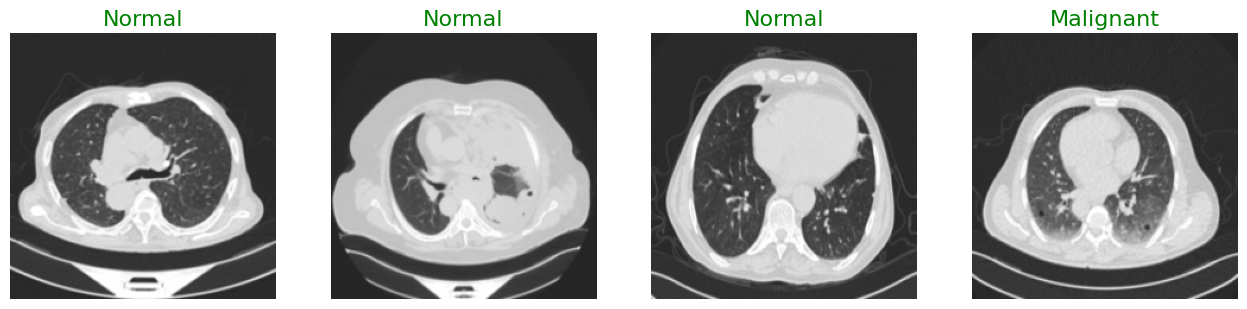

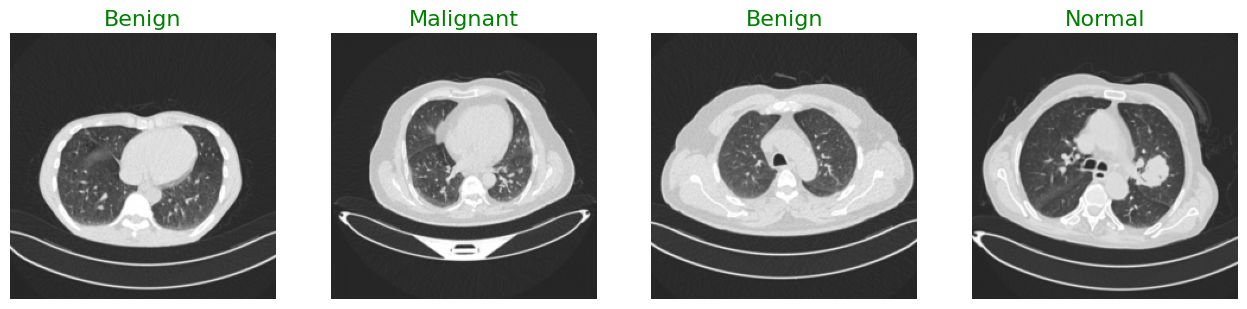

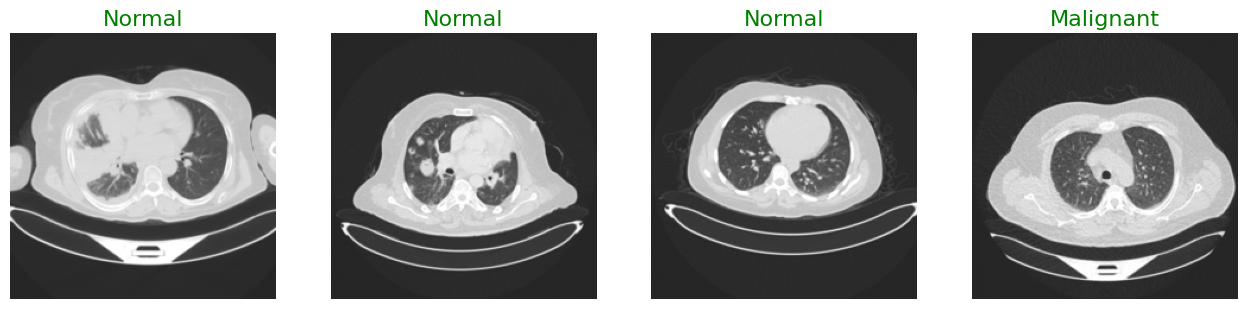

In [ ]:
#@title **3.2 Visualising the Data Loaders**

import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(data_loader, num_images=5):
    # Get a batch of images and labels from the data loader
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Undo the normalization (from [-1, 1] to [0, 1])
    images = torch.clamp(images, 0, 1)  # Clip values to [0, 1] range
    # Convert the images to NumPy format
    images = images.numpy()
    # Setup the plot
    plt.figure(figsize=(20, 20))

    for i in range(min(num_images, len(labels))):
        plt.subplot(5, 5, i + 1)  # 5x5 grid for up to 25 images
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img)
        plt.title(f"{ID_to_label[labels[i].item()].capitalize()}", color="green", fontsize=16)
        plt.axis('off')

    plt.show()

display_sample_images(train, num_images=5)
display_sample_images(test, num_images=5)
display_sample_images(val, num_images=5)

# **4. CvT Model Implementation**

In [ ]:
#@title **4.1 CvT Implementation**
"""
Adapted From: https://github.com/lucidrains/vit-pytorch/tree/main/vit_pytorch
"""

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def group_dict_by_key(cond, d):
    return_val = [dict(), dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)

def group_by_key_prefix_and_remove_prefix(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(lambda x: x.startswith(prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs

class LayerNorm(nn.Module): # layernorm, but done in the channel dimension #1
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            LayerNorm(dim),
            nn.Conv2d(dim, dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(dim * mult, dim, 1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.BatchNorm2d(dim_in),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        padding = proj_kernel // 2
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_q = DepthWiseConv2d(dim, inner_dim, proj_kernel, padding = padding, stride = 1, bias = False)
        self.to_kv = DepthWiseConv2d(dim, inner_dim * 2, proj_kernel, padding = padding, stride = kv_proj_stride, bias = False)
        self.to_out = nn.Sequential(
            nn.Conv2d(inner_dim, dim, 1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        shape = x.shape
        b, n, _, y, h = *shape, self.heads
        x = self.norm(x)
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> (b h) (x y) d', h = h), (q, k, v))
        dots = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, y = y)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, depth, heads, dim_head = 64, mlp_mult = 4, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, proj_kernel = proj_kernel, kv_proj_stride = kv_proj_stride, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_mult, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class CvT(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        s1_emb_dim = 64,
        s1_emb_kernel = 7,
        s1_emb_stride = 4,
        s1_proj_kernel = 3,
        s1_kv_proj_stride = 2,
        s1_heads = 1,
        s1_depth = 1,
        s1_mlp_mult = 4,
        s2_emb_dim = 192,
        s2_emb_kernel = 3,
        s2_emb_stride = 2,
        s2_proj_kernel = 3,
        s2_kv_proj_stride = 2,
        s2_heads = 3,
        s2_depth = 2,
        s2_mlp_mult = 4,
        s3_emb_dim = 384,
        s3_emb_kernel = 3,
        s3_emb_stride = 2,
        s3_proj_kernel = 3,
        s3_kv_proj_stride = 2,
        s3_heads = 6,
        s3_depth = 10,
        s3_mlp_mult = 4,
        dropout = 0.,
        channels = 3
    ):
        super().__init__()
        kwargs = dict(locals())
        dim = channels
        layers = []

        for prefix in ('s1', 's2', 's3'):
            config, kwargs = group_by_key_prefix_and_remove_prefix(f'{prefix}_', kwargs)

            layers.append(nn.Sequential(
                nn.Conv2d(dim, config['emb_dim'], kernel_size = config['emb_kernel'], padding = (config['emb_kernel'] // 2), stride = config['emb_stride']),
                LayerNorm(config['emb_dim']),
                Transformer(dim = config['emb_dim'], proj_kernel = config['proj_kernel'], kv_proj_stride = config['kv_proj_stride'], depth = config['depth'], heads = config['heads'], mlp_mult = config['mlp_mult'], dropout = dropout)
            ))

            dim = config['emb_dim']

        self.layers = nn.Sequential(*layers)
        self.to_logits = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Rearrange('... () () -> ...'),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        latents = self.layers(x)
        return self.to_logits(latents)

# **5. Training the Model**

## **5.1 Training Utilities**

In [ ]:
#@title **5.1.1 Device**

# Initialised Early - Needed for Misclassification Handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title **5.1.2 EarlyStopping Callback**

# EarlyStopping class to stop training if no improvement after a given patience
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait before stopping when validation loss is not improving.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # reset the counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### **5.1.3 Misclassification Handling**

#### **5.1.3.1 Visualising Misclassification - Distribution Graphs for Dataframes**

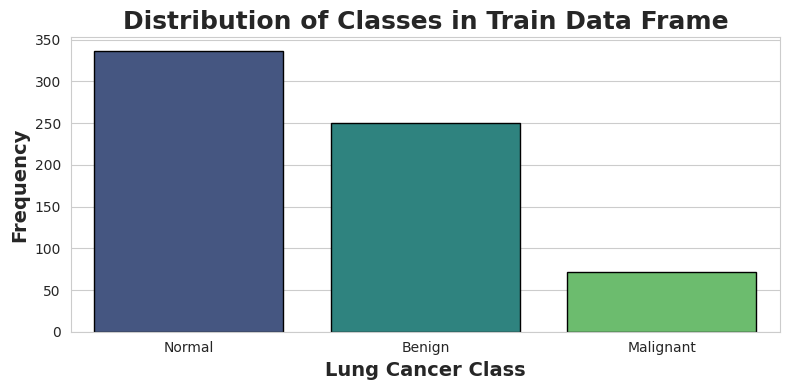

In [ ]:
#@title **(a) Distribution Graph: train_df**
attribute = 'labels'
title = 'Distribution of Classes in Train Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(train_df, attribute, title, x_label, y_label)

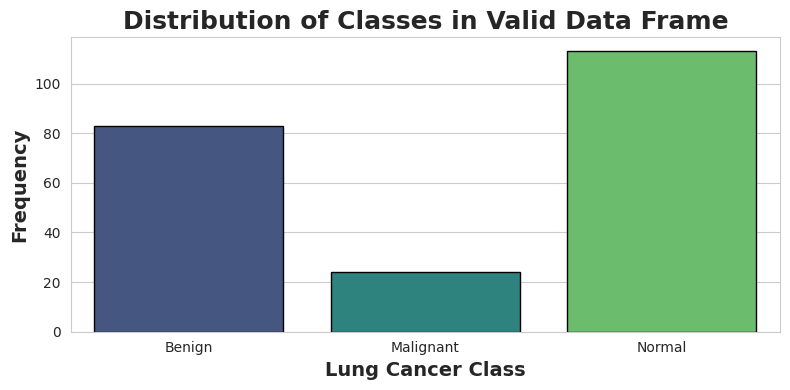

In [ ]:
#@title **(b) Distribution Graph: val_df**
attribute = 'labels'
title = 'Distribution of Classes in Valid Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(val_df, attribute, title, x_label, y_label)

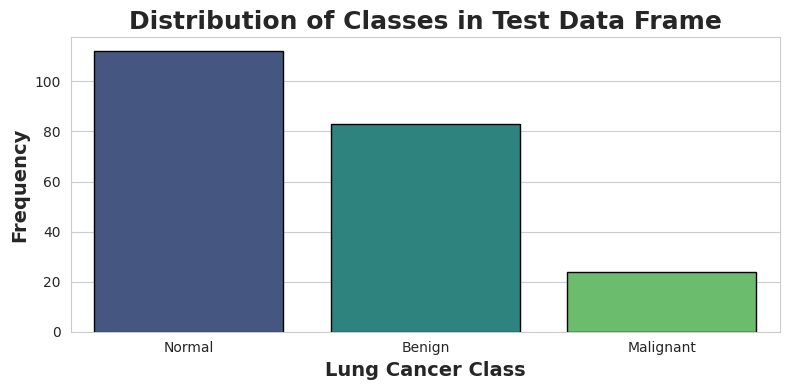

In [ ]:
#@title **(c) Distribution Graph: test_df**
attribute = 'labels'
title = 'Distribution of Classes in Test Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(test_df, attribute, title, x_label, y_label)

#### **5.1.3.2 Handling Misclassification**

**How to handle the imbalance of the distrbution of classes?**
We can compute weights for the Loss Function,

In [ ]:
from collections import Counter
import torch

# NOTE:
# need to recalculate weights for optimizer
# Convert label to tensor (use the same label mapping)
# label_to_ID = {"benign": 0, "malignant": 1, "normal": 2}
# ID_to_label = {0: "benign", 1: "malignant", 2: "normal"}

def get_weights(df):
    labels = df.iloc[:, 1].map(label_to_ID)
    label_counts = Counter(labels)
    total_samples = len(labels)
    print(f"Label Frequencies in Dataframe: {label_counts}")

    num_classes = len(label_to_ID)
    class_weights = []

    # Calculate the weight for each class (inversely proportional to its frequency)
    for ID in label_counts.keys():
        class_weight = total_samples / (num_classes * label_counts[ID])
        class_weights.append(class_weight)

    # Convert to a PyTorch Tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"Class Weights: {class_weights}\n")

    return class_weights

# higher weights are assigned to labels with lower count
train_weights = get_weights(train_df)
val_weights = get_weights(val_df)
test_weights = get_weights(test_df)

def get_universal_weight():
    # Average the weights from training, validation, and testing
    universal_weight = (train_weights + val_weights + test_weights) / 3
    print(f"Universal Class Weights: {universal_weight}")
    return universal_weight

universal_weight = get_universal_weight()

Label Frequencies in Dataframe: Counter({2: 336, 0: 250, 1: 72})
Class Weights: tensor([0.6528, 0.8773, 3.0463], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 113, 0: 83, 1: 24})
Class Weights: tensor([0.8835, 3.0556, 0.6490], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 112, 0: 83, 1: 24})
Class Weights: tensor([0.6518, 0.8795, 3.0417], device='cuda:0')

Universal Class Weights: tensor([0.7294, 1.6041, 2.2456], device='cuda:0')


## **5.2 Training the Model**

In [ ]:
#@title **5.2.1 Training Parameters**

EXP_NAME = "CvT_Ground_Up" # @param {type:"string", description:"Description of this model."}
EPOCHS = 20 # @param {type:"integer", description:"Number of epochs to train model."}
NUM_CLASSES = 3 # @param {type:"integer", description:"Number of classes for classification."}
PATCH_SIZE = 32 # @param {type:"integer", description:"The size of the patches into which the input image is divided. 32x32"}
LEARNING_RATE = 3e-5 # @param {type:"number", description:"Learning rate."}
GAMMA = 0.7 # @param {type:"number", description:"Decay learning rate by this value."}
STEP_SIZE = 2 # @param {type:"integer", description:"Decay learning rate every this number of epochs."}

# PATCH_SIZE Calculation: (224/16)x(224/16) = 14×14 = 196 Patches

**Model Parameters:**
- **image_size**: int.
Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
- **patch_size**: int. Size of patches. image_size must be divisible by patch_size. The number of patches is:  n = (image_size // patch_size) ** 2 and n must be greater than 16.
- **num_classes**: int.
Number of classes to classify.
- **dim**: int.
Last dimension of output tensor after linear transformation nn.Linear(..., dim).
- **depth**: int.
Number of Transformer blocks.
- **heads**: int.
Number of heads in Multi-head Attention layer.
- **mlp_dim**: int.
Dimension of the MLP (FeedForward) layer.
- **channels**: int, default 3.
Number of image's channels.
- **dropout**: float between [0, 1], default 0..
Dropout rate.
- **emb_dropout**: float between [0, 1], default 0.
Embedding dropout rate.
- **pool**: string, either cls token pooling or mean pooling

In [ ]:
#@title **5.2.2 Setting Up the Model: CvT**

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss(weight=universal_weight)

# loss functions - weighted for misclassification
# train_criterion = nn.CrossEntropyLoss(weight=train_weights)
# val_criterion = nn.CrossEntropyLoss(weight=val_weights)
# test_criterion = nn.CrossEntropyLoss(weight=test_weights)

model = CvT(
    num_classes = NUM_CLASSES,
    s1_emb_dim = 128,        # stage 1 - adjust for overall dim = 1024
    s1_emb_kernel = 7,       # keep this kernel size for spatial resolution
    s1_emb_stride = 4,       # stride for down-sampling
    s1_proj_kernel = 3,      # projection kernel for attention
    s1_kv_proj_stride = 2,   # key/value projection stride for attention
    s1_heads = 2,            # match overall heads (we'll add up to 16 across stages)
    s1_depth = 2,            # distribute depth across stages (depth = 6 in total)
    s1_mlp_mult = 4,         # expansion factor for feedforward layers

    s2_emb_dim = 256,        # stage 2 - increase dim
    s2_emb_kernel = 3,       # keep kernel size smaller to capture finer details
    s2_emb_stride = 2,       # down-sample further
    s2_proj_kernel = 3,      # projection kernel for attention
    s2_kv_proj_stride = 2,   # key/value projection stride for attention
    s2_heads = 4,            # more heads at higher stages
    s2_depth = 2,            # add depth to this stage
    s2_mlp_mult = 4,         # feedforward expansion factor

    s3_emb_dim = 512,        # stage 3 - further increase dimension
    s3_emb_kernel = 3,       # small kernel for attention
    s3_emb_stride = 2,       # stride to reduce spatial size
    s3_proj_kernel = 3,      # projection kernel for attention
    s3_kv_proj_stride = 2,   # key/value projection stride
    s3_heads = 10,           # high attention heads
    s3_depth = 2,            # remaining depth allocated to this stage
    s3_mlp_mult = 4,         # feedforward expansion factor

    dropout = 0.1
).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# scheduler
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
#@title **5.2.3 Training the Model**

import torch
import torchmetrics
from torchmetrics.classification import F1Score, Precision, Recall, AUROC

recall_metric = torchmetrics.Recall(task="multiclass", average='weighted', num_classes=NUM_CLASSES).to(device)
precision_metric = torchmetrics.Precision(task="multiclass", average='weighted', num_classes=NUM_CLASSES).to(device)
f1_metric = torchmetrics.F1Score(task="multiclass", average='weighted', num_classes=NUM_CLASSES).to(device)
auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES).to(device)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0
    epoch_auc = 0

    for data, label in tqdm(train):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accuracy, loss
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train)
        epoch_loss += loss / len(train)

        # recall, precision, f1_score, auc_roc
        preds = output.argmax(dim=1)
        epoch_f1 += f1_metric(preds, label).item() / len(train)
        epoch_precision += precision_metric(preds, label).item() / len(train)
        epoch_recall += recall_metric(preds, label).item() / len(train)
        epoch_auc += auc_metric(output, label).item() / len(train)

    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        val_loss = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_auc = 0

        for data, label in val:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            # accuracy, loss
            acc = (val_output.argmax(dim=1) == label).float().mean()
            val_accuracy += acc / len(val)
            val_loss += val_loss / len(val)

            # recall, precision, f1_score, auc_roc
            preds = val_output.argmax(dim=1)
            val_f1 += f1_metric(preds, label).item() / len(val)
            val_precision += precision_metric(preds, label).item() / len(val)
            val_recall += recall_metric(preds, label).item() / len(val)
            val_auc += auc_metric(val_output, label).item() / len(val)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{len(train)}/{len(train)} [==============================] - "
          f"loss: {epoch_loss:.4f} - accuracy: {epoch_accuracy:.4f} - "
          f"recall: {epoch_recall:.4f} - precision: {epoch_precision:.4f} - "
          f"f1_score: {epoch_f1:.4f} - auc: {epoch_auc:.4f} - "
          f"val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f} - "
          f"val_recall: {val_recall:.4f} - val_precision: {val_precision:.4f} - "
          f"val_f1_score: {val_f1:.4f} - val_auc: {val_auc:.4f} - "
          f"lr: {optimizer.param_groups[0]['lr']:.4f}")

    scheduler.step()

  0%|          | 0/165 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 1/20
165/165 [==============================] - loss: 0.8817 - accuracy: 0.5076 - recall: 0.5076 - precision: 0.3554 - f1_score: 0.3988 - auc: 0.4227 - val_loss: 0.3180 - val_accuracy: 0.5136 - val_recall: 0.5136 - val_precision: 0.3239 - val_f1_score: 0.3864 - val_auc: 0.5051 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2/20
165/165 [==============================] - loss: 0.8149 - accuracy: 0.5167 - recall: 0.5167 - precision: 0.3732 - f1_score: 0.4129 - auc: 0.4653 - val_loss: 0.3986 - val_accuracy: 0.6636 - val_recall: 0.6636 - val_precision: 0.6492 - val_f1_score: 0.6303 - val_auc: 0.5520 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3/20
165/165 [==============================] - loss: 0.7139 - accuracy: 0.6152 - recall: 0.6152 - precision: 0.5775 - f1_score: 0.5592 - auc: 0.5719 - val_loss: 0.2165 - val_accuracy: 0.7000 - val_recall: 0.7000 - val_precision: 0.7455 - val_f1_score: 0.6903 - val_auc: 0.5838 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4/20
165/165 [==============================] - loss: 0.6951 - accuracy: 0.6288 - recall: 0.6288 - precision: 0.6668 - f1_score: 0.6048 - auc: 0.5537 - val_loss: 0.4771 - val_accuracy: 0.7364 - val_recall: 0.7364 - val_precision: 0.7064 - val_f1_score: 0.7024 - val_auc: 0.5975 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5/20
165/165 [==============================] - loss: 0.6150 - accuracy: 0.6970 - recall: 0.6970 - precision: 0.7062 - f1_score: 0.6654 - auc: 0.5990 - val_loss: 0.4091 - val_accuracy: 0.7318 - val_recall: 0.7318 - val_precision: 0.7572 - val_f1_score: 0.7151 - val_auc: 0.6000 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6/20
165/165 [==============================] - loss: 0.5699 - accuracy: 0.6985 - recall: 0.6985 - precision: 0.7126 - f1_score: 0.6703 - auc: 0.6062 - val_loss: 0.5383 - val_accuracy: 0.7500 - val_recall: 0.7500 - val_precision: 0.7587 - val_f1_score: 0.7316 - val_auc: 0.6056 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7/20
165/165 [==============================] - loss: 0.5391 - accuracy: 0.7318 - recall: 0.7318 - precision: 0.7270 - f1_score: 0.7027 - auc: 0.6237 - val_loss: 0.3020 - val_accuracy: 0.7864 - val_recall: 0.7864 - val_precision: 0.7481 - val_f1_score: 0.7430 - val_auc: 0.6722 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8/20
165/165 [==============================] - loss: 0.5550 - accuracy: 0.7364 - recall: 0.7364 - precision: 0.7499 - f1_score: 0.7169 - auc: 0.5769 - val_loss: 0.4735 - val_accuracy: 0.7909 - val_recall: 0.7909 - val_precision: 0.8186 - val_f1_score: 0.7769 - val_auc: 0.6404 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9/20
165/165 [==============================] - loss: 0.5322 - accuracy: 0.7500 - recall: 0.7500 - precision: 0.7596 - f1_score: 0.7293 - auc: 0.5865 - val_loss: 0.5791 - val_accuracy: 0.8091 - val_recall: 0.8091 - val_precision: 0.7814 - val_f1_score: 0.7742 - val_auc: 0.6399 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10/20
165/165 [==============================] - loss: 0.5193 - accuracy: 0.7773 - recall: 0.7773 - precision: 0.7814 - f1_score: 0.7575 - auc: 0.5993 - val_loss: 0.1853 - val_accuracy: 0.7773 - val_recall: 0.7773 - val_precision: 0.7977 - val_f1_score: 0.7708 - val_auc: 0.5980 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11/20
165/165 [==============================] - loss: 0.4839 - accuracy: 0.7636 - recall: 0.7636 - precision: 0.7657 - f1_score: 0.7410 - auc: 0.6231 - val_loss: 0.1708 - val_accuracy: 0.8045 - val_recall: 0.8045 - val_precision: 0.8106 - val_f1_score: 0.7903 - val_auc: 0.6020 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12/20
165/165 [==============================] - loss: 0.4844 - accuracy: 0.7727 - recall: 0.7727 - precision: 0.7658 - f1_score: 0.7461 - auc: 0.6375 - val_loss: 0.7750 - val_accuracy: 0.7955 - val_recall: 0.7955 - val_precision: 0.7871 - val_f1_score: 0.7731 - val_auc: 0.6444 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13/20
165/165 [==============================] - loss: 0.4805 - accuracy: 0.7682 - recall: 0.7682 - precision: 0.7846 - f1_score: 0.7523 - auc: 0.6263 - val_loss: 0.5282 - val_accuracy: 0.8136 - val_recall: 0.8136 - val_precision: 0.7886 - val_f1_score: 0.7865 - val_auc: 0.6768 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14/20
165/165 [==============================] - loss: 0.4898 - accuracy: 0.7545 - recall: 0.7545 - precision: 0.7629 - f1_score: 0.7365 - auc: 0.5956 - val_loss: 0.4568 - val_accuracy: 0.7955 - val_recall: 0.7955 - val_precision: 0.7905 - val_f1_score: 0.7719 - val_auc: 0.6808 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15/20
165/165 [==============================] - loss: 0.4537 - accuracy: 0.7848 - recall: 0.7848 - precision: 0.7923 - f1_score: 0.7649 - auc: 0.6322 - val_loss: 0.6061 - val_accuracy: 0.7955 - val_recall: 0.7955 - val_precision: 0.7727 - val_f1_score: 0.7662 - val_auc: 0.6561 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 16/20
165/165 [==============================] - loss: 0.4359 - accuracy: 0.7909 - recall: 0.7909 - precision: 0.7818 - f1_score: 0.7631 - auc: 0.6268 - val_loss: 0.1852 - val_accuracy: 0.8136 - val_recall: 0.8136 - val_precision: 0.8072 - val_f1_score: 0.7926 - val_auc: 0.6515 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17/20
165/165 [==============================] - loss: 0.4409 - accuracy: 0.8000 - recall: 0.8000 - precision: 0.7946 - f1_score: 0.7772 - auc: 0.6475 - val_loss: 0.1281 - val_accuracy: 0.8091 - val_recall: 0.8091 - val_precision: 0.8087 - val_f1_score: 0.7890 - val_auc: 0.6444 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18/20
165/165 [==============================] - loss: 0.4325 - accuracy: 0.8030 - recall: 0.8030 - precision: 0.7907 - f1_score: 0.7780 - auc: 0.6483 - val_loss: 0.4121 - val_accuracy: 0.8182 - val_recall: 0.8182 - val_precision: 0.7932 - val_f1_score: 0.7935 - val_auc: 0.6652 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 19/20
165/165 [==============================] - loss: 0.4408 - accuracy: 0.7803 - recall: 0.7803 - precision: 0.7801 - f1_score: 0.7572 - auc: 0.6599 - val_loss: 0.6433 - val_accuracy: 0.8182 - val_recall: 0.8182 - val_precision: 0.8110 - val_f1_score: 0.7989 - val_auc: 0.5990 - lr: 0.0000


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20/20
165/165 [==============================] - loss: 0.4465 - accuracy: 0.7939 - recall: 0.7939 - precision: 0.7818 - f1_score: 0.7730 - auc: 0.6116 - val_loss: 0.4019 - val_accuracy: 0.8182 - val_recall: 0.8182 - val_precision: 0.8057 - val_f1_score: 0.7923 - val_auc: 0.6141 - lr: 0.0000


# **6. Evaluating the Model**

In [ ]:
#@title **6.1 Metric Evaluation**
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Initialize lists to store true labels, predicted labels, and predicted probabilities
all_preds = []
all_labels = []
all_probs = []

# Initialize variable to store the cumulative loss
cumulative_loss = 0.0

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for data, label in tqdm(test):
        data = data.to(device)
        label = label.to(device)

        # Forward pass
        output = model(data)
        preds = output.argmax(dim=1)  # Get predicted labels (class with max probability)

        # Calculate loss for this batch
        loss = criterion(output, label)
        cumulative_loss += loss.item()  # Accumulate the batch loss

        # Get the predicted probabilities for ROC-AUC (softmax of the output)
        probs = nn.Softmax(dim=1)(output)  # Apply softmax to get probabilities

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for further analysis
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Calculate the average loss across all batches
average_loss = cumulative_loss / len(test)

# Print accuracy and loss
print(f"\n\nAccuracy: {accuracy} ({accuracy:.2f}%)")
print(f"Average Loss: {average_loss} ({average_loss:.2f}%)")

# Compute additional metrics
F1_Score = f1_score(all_labels, all_preds, average='macro', zero_division=0)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

# Print metrics
print(f"F1-score: {F1_Score} ({F1_Score:.2f}%)")
print(f"Precision: {precision} ({precision:.2f}%)")
print(f"Recall: {recall} ({recall:.2f}%)")
print(f"AUC-ROC: {roc_auc} ({roc_auc:.2f}%)")

100%|██████████| 55/55 [00:02<00:00, 25.16it/s]



Accuracy: 0.8264840182648402 (0.83%)
Average Loss: 0.41371365521441805 (0.41%)
F1-score: 0.6399220269366991 (0.64%)
Precision: 0.6698135594969098 (0.67%)
Recall: 0.6431798623063684 (0.64%)
AUC-ROC: 0.9004143649005946 (0.90%)


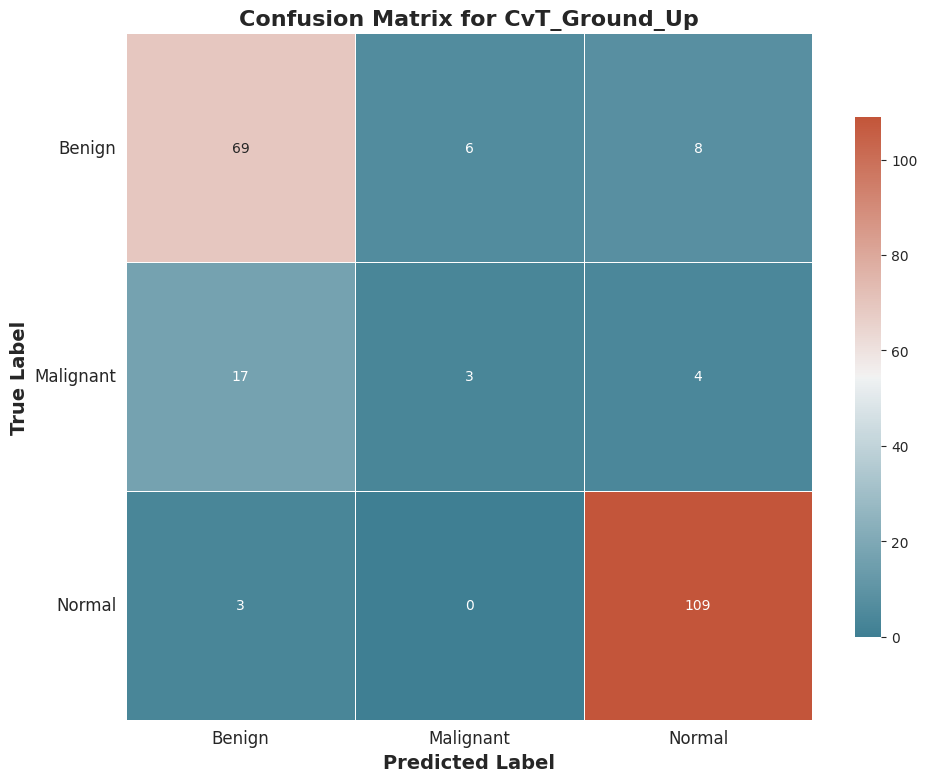

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title **6.2 Confusion Matrix**
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict on the test set
y_true = all_labels
y_pred = all_preds

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Set the figure size and resolution
plt.figure(figsize=(10, 8), dpi=100)

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the confusion matrix heatmap
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75},
    xticklabels=[label.capitalize() for label in label_to_ID.keys()],
    yticklabels=[label.capitalize() for label in label_to_ID.keys()]
)

# Add labels and title with increased font size
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix for ' + EXP_NAME, fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()
plt.savefig(EXP_NAME + '_Confusion_Matrix_Heatmap.png', format='png', dpi=300)

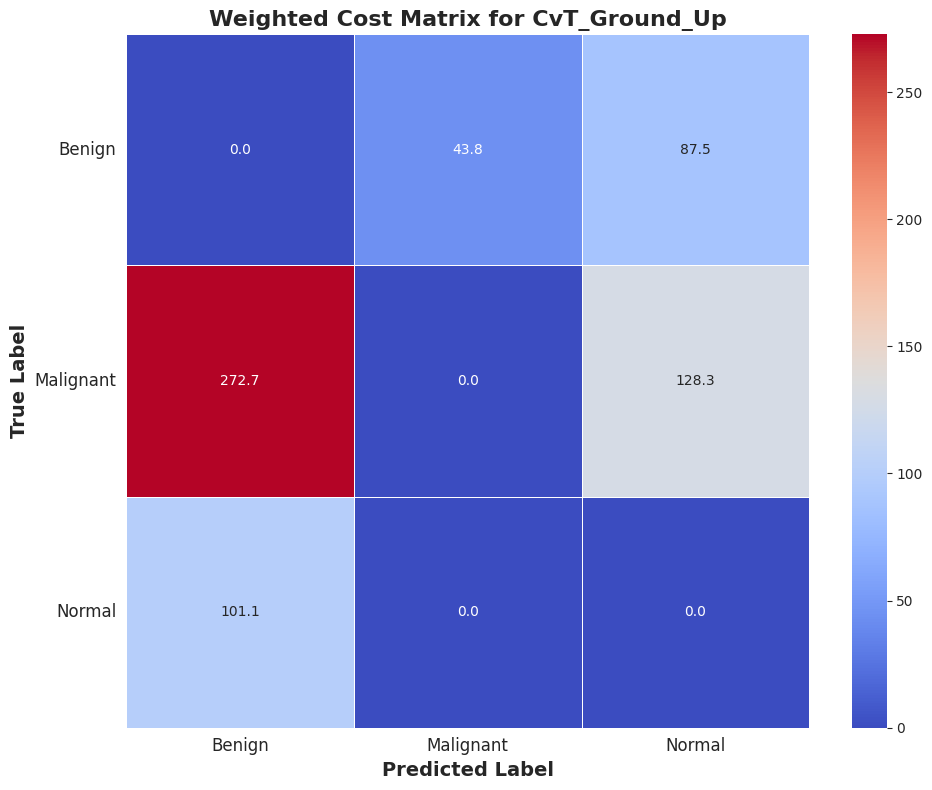

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title **6.3 Cost Matrix**

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate class weights using the get_weights function
weights = universal_weight.cpu().numpy()

# classes = ['benign', 'malignant', 'normal']
# Original cost matrix for multi-class classification (3 classes)
original_cost_matrix = np.array([
    [0, 10, 15],  # Cost of predicting benign as [benign, malignant, normal]
    [10, 0, 20],  # Cost of predicting malignant as [benign, malignant, normal]
    [15, 20, 0]   # Cost of predicting normal as [benign, malignant, normal]
])

# Adjust the cost matrix by multiplying each row by the corresponding class weight
# Each row in the cost matrix corresponds to the true label, so we scale by the respective class weight
weighted_cost_matrix = original_cost_matrix * weights[:, np.newaxis]

# Generate the confusion matrix from your model's predictions
conf_matrix = confusion_matrix(y_true, y_pred)

# Multiply the confusion matrix by the adjusted cost matrix
cost_conf_matrix = conf_matrix * weighted_cost_matrix

# Plot the cost matrix heatmap
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(cost_conf_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5,
            xticklabels=[label.capitalize() for label in label_to_ID.keys()],
            yticklabels=[label.capitalize() for label in label_to_ID.keys()])

plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Weighted Cost Matrix for ' + EXP_NAME, fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig(EXP_NAME + '_Weighted_Cost_Matrix_Heatmap.png', format='png', dpi=300)

# **7. Downloading the Model**

In [ ]:
import torch

# Define the path where you want to save the model
model_save_path = EXP_NAME + "_Model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

# zip the important folders
!zip -r /content/CvT_Ground_Up_Model.zip /content/CvT_Ground_Up_Model.pth

!mkdir -p /content/drive/MyDrive/Research  # Create the folder if it doesn't exist
!mv /content/CvT_Ground_Up_Model.zip /content/drive/MyDrive/Research
!mv /content/CvT_Ground_Up_Weighted_Cost_Matrix_Heatmap.png /content/drive/MyDrive/Research
!mv /content/CvT_Ground_Up_Confusion_Matrix_Heatmap.png /content/drive/MyDrive/Research

  adding: content/CvT_Ground_Up_Model.pth (deflated 8%)
